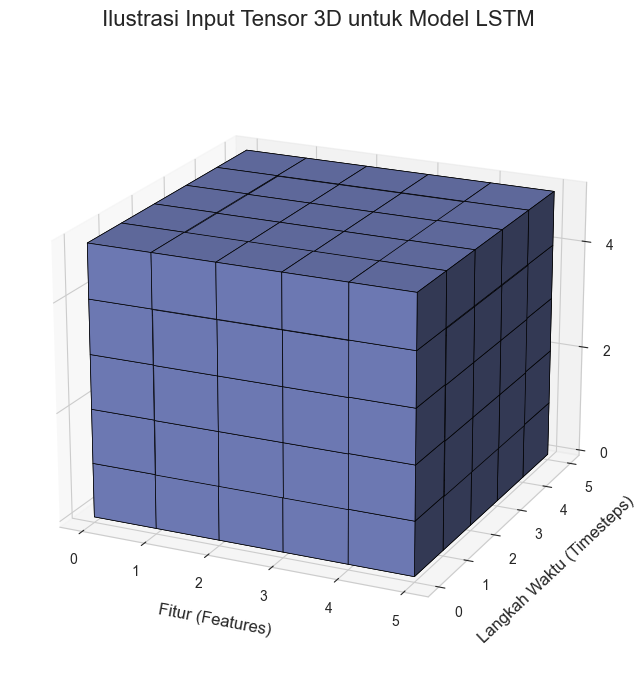

In [8]:
import numpy as np
import requests
from typing import List, Dict, Any

from stock_indicators.indicators.common.quote import Quote
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

from tensorflow.python.keras.layers import SimpleRNN

In [9]:
class StockResponse:
    stock_data: List[Quote]

    def __init__(self, stock_data: List[Quote]):
        self.stock_data = stock_data

    @classmethod
    def from_json(cls, data: Dict[str, Any]) -> 'StockResponse':
        result = data["chart"]["result"][0]
        timestamps = result["timestamp"]
        indicators = result["indicators"]["quote"][0]

        stock_data: List[Quote] = []
        for i in range(len(timestamps)):
            date = datetime.fromtimestamp(timestamps[i])
            open_price = indicators["open"][i]
            high = indicators["high"][i]
            low = indicators["low"][i]
            close = indicators["close"][i]
            volume = indicators["volume"][i]

            # Skip if any value is None
            if 0 in (open_price, high, low, close, volume):
                continue

            stock_data.append(Quote(date, open_price, high, low, close, volume))

        return cls(stock_data=stock_data)

    def to_dataframe(self) -> pd.DataFrame:
        data = [[
            stock.date,
            stock.open,
            stock.high,
            stock.low,
            stock.close,
            stock.volume
        ] for stock in self.stock_data]
        return pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

    def to_numpy(self) -> np.ndarray:
        data = [[
            stock.date,
            stock.open,
            stock.high,
            stock.low,
            stock.close,
            stock.volume
        ] for stock in self.stock_data]
        return np.array(data)

In [10]:
def compute_and_add_indicators(stock_data: List, df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute technical indicators and add them to the DataFrame.

    Parameters:
    - stock_data (List): List of Quote objects containing stock data.
    - df (pd.DataFrame): DataFrame containing stock data.

    Returns:
    - pd.DataFrame: Updated DataFrame with technical indicators.
    """
    # Compute Technical Indicators
    sma = indicators.get_sma(stock_data, 14)
    rsi = indicators.get_rsi(stock_data, 14)
    macd = indicators.get_macd(stock_data)
    bollinger = indicators.get_bollinger_bands(stock_data, 20)
    atr = indicators.get_atr(stock_data, 14)
    wma = indicators.get_wma(stock_data, 14)
    tr = indicators.get_tr(stock_data)
    stoch_oscillator = indicators.get_stoch(stock_data)
    william = indicators.get_williams_r(stock_data)
    ema = indicators.get_ema(stock_data, 14)
    obv = indicators.get_obv(stock_data)
    ichimoku = indicators.get_ichimoku(stock_data)
    vwap = indicators.get_vwap(stock_data)
    smi = indicators.get_smi(stock_data)
    dema = indicators.get_dema(stock_data, 14)
    mfi = indicators.get_mfi(stock_data)
    cci = indicators.get_cci(stock_data)
    cmo = indicators.get_cmo(stock_data, 14)

    # Add indicators to the DataFrame
    for i in range(len(df)):
        df.loc[i, 'SMA'] = sma[i].sma
        df.loc[i, 'RSI'] = rsi[i].rsi
        df.loc[i, 'MACD'] = macd[i].macd
        df.loc[i, 'bollinger_upper'] = bollinger[i].upper_band
        df.loc[i, 'bollinger_lower'] = bollinger[i].lower_band
        df.loc[i, 'ATR'] = atr[i].atr
        df.loc[i, 'WMA'] = wma[i].wma
        df.loc[i, 'TR'] = tr[i].tr
        df.loc[i, '%K'] = stoch_oscillator[i].k
        df.loc[i, '%D'] = stoch_oscillator[i].d
        df.loc[i, '%R'] = william[i].williams_r
        df.loc[i, 'EMA'] = ema[i].ema
        df.loc[i, 'OBV'] = obv[i].obv
        df.loc[i, 'Ichimoku'] = ichimoku[i].kijun_sen
        df.loc[i, 'VWAP'] = vwap[i].vwap
        df.loc[i, 'SMI'] = smi[i].smi
        df.loc[i, 'DEMA'] = dema[i].dema
        df.loc[i, 'MFI'] = mfi[i].mfi
        df.loc[i, 'CCI'] = cci[i].cci
        df.loc[i, 'CMO'] = cmo[i].cmo

    # Handle missing values or NaNs
    df = df.dropna()

    # Convert columns to appropriate data types
    df = df.astype({
        'close': 'float64',
        'SMA': 'float64',
        'RSI': 'float64',
        'MACD': 'float64',
        'bollinger_upper': 'float64',
        'bollinger_lower': 'float64',
        'ATR': 'float64',
        'WMA': 'float64',
        'TR': 'float64',
        '%K': 'float64',
        '%D': 'float64',
        '%R': 'float64',
        'EMA': 'float64',
        'OBV': 'float64',
        'Ichimoku': 'float64',
        'VWAP': 'float64',
        'SMI': 'float64',
        'DEMA': 'float64',
        'MFI': 'float64',
        'CCI': 'float64',
        'CMO': 'float64'
    })

    # Verify data types (optional, can be disabled to save computation)
    # print(df.dtypes)

    return df

In [11]:
from pytz import timezone
from datetime import datetime


def convert_to_unix_timestamp(date_str: str) -> int:
    jakarta_tz = timezone("Asia/Jakarta")
    current_time = datetime.now(jakarta_tz)
    date_with_time = datetime.strptime(date_str, "%Y-%m-%d").replace(
        hour=current_time.hour,
        minute=current_time.minute,
        second=current_time.second,
        tzinfo=jakarta_tz
    )
    return int(date_with_time.timestamp())


In [12]:
# Define the from and to dates
from_date = "2010-01-01"  # Input format: YYYY-MM-DD
to_date = "2024-12-31"  # Input format: YYYY-MM-DD

# Convert the dates to Unix timestamps (seconds since epoch)
period1 = convert_to_unix_timestamp(from_date)
period2 = convert_to_unix_timestamp(to_date)

# Update the Yahoo Finance URL with dynamic dates
stock_url = f"https://query2.finance.yahoo.com/v8/finance/chart/BBCA.JK?period1={period1}&period2={period2}&interval=1d"
headers = {
    "Content-Type": "application/json",
    "User-Agent": "Chrome/58.0.3029.110"
}

r = requests.get(stock_url, headers=headers)
print(r.text)
r.json()

{"chart":{"result":[{"meta":{"currency":"IDR","symbol":"BBCA.JK","exchangeName":"JKT","fullExchangeName":"Jakarta","instrumentType":"EQUITY","firstTradeDate":1086660000,"regularMarketTime":1749114894,"hasPrePostMarketData":false,"gmtoffset":25200,"timezone":"WIB","exchangeTimezoneName":"Asia/Jakarta","regularMarketPrice":8925.0,"fiftyTwoWeekHigh":10950.0,"fiftyTwoWeekLow":7275.0,"regularMarketDayHigh":9050.0,"regularMarketDayLow":8900.0,"regularMarketVolume":95529000,"longName":"PT Bank Central Asia Tbk","shortName":"Bank Central Asia Tbk","chartPreviousClose":970.0,"priceHint":2,"currentTradingPeriod":{"pre":{"timezone":"WIB","end":1749088800,"start":1749088800,"gmtoffset":25200},"regular":{"timezone":"WIB","end":1749114900,"start":1749088800,"gmtoffset":25200},"post":{"timezone":"WIB","end":1749114900,"start":1749114900,"gmtoffset":25200}},"dataGranularity":"1d","range":"","validRanges":["1d","5d","1mo","3mo","6mo","1y","2y","5y","10y","ytd","max"]},"timestamp":[1262570400,1262656800

{'chart': {'result': [{'meta': {'currency': 'IDR',
     'symbol': 'BBCA.JK',
     'exchangeName': 'JKT',
     'fullExchangeName': 'Jakarta',
     'instrumentType': 'EQUITY',
     'firstTradeDate': 1086660000,
     'regularMarketTime': 1749114894,
     'hasPrePostMarketData': False,
     'gmtoffset': 25200,
     'timezone': 'WIB',
     'exchangeTimezoneName': 'Asia/Jakarta',
     'regularMarketPrice': 8925.0,
     'fiftyTwoWeekHigh': 10950.0,
     'fiftyTwoWeekLow': 7275.0,
     'regularMarketDayHigh': 9050.0,
     'regularMarketDayLow': 8900.0,
     'regularMarketVolume': 95529000,
     'longName': 'PT Bank Central Asia Tbk',
     'shortName': 'Bank Central Asia Tbk',
     'chartPreviousClose': 970.0,
     'priceHint': 2,
     'currentTradingPeriod': {'pre': {'timezone': 'WIB',
       'end': 1749088800,
       'start': 1749088800,
       'gmtoffset': 25200},
      'regular': {'timezone': 'WIB',
       'end': 1749114900,
       'start': 1749088800,
       'gmtoffset': 25200},
      'pos

# Checkpoint to restart from

In [39]:
json_data = r.json()
stock_response = StockResponse.from_json(json_data)
df = stock_response.to_dataframe()
df

,date,open,high,low,close,volume
0,2010-01-04 09:00:00,1010.0,1010.0,965.0,1010.0,77812500
1,2010-01-05 09:00:00,1020.0,1020.0,990.0,1020.0,44442500
2,2010-01-06 09:00:00,990.0,1020.0,990.0,990.0,27782500
3,2010-01-07 09:00:00,995.0,995.0,965.0,995.0,38632500
4,2010-01-08 09:00:00,970.0,995.0,970.0,970.0,27427500
...,...,...,...,...,...,...
3619,2024-12-20 09:00:00,9650.0,9750.0,9625.0,9650.0,91576900
3620,2024-12-23 09:00:00,9700.0,9850.0,9700.0,9775.0,43292100
3621,2024-12-24 09:00:00,9850.0,9900.0,9750.0,9750.0,32415700
3622,2024-12-27 09:00:00,9800.0,9825.0,9725.0,9800.0,24016700


In [40]:
# init variable for dataset to be used
# remove all column except for date and move the close price to y
df = stock_response.to_dataframe()
# df = df.drop(columns=['open', 'high', 'low', 'volume'])

# Add column for the next day close price
df['next_day_price_move'] = df['close'].shift(-1)

# Drop the last row as it will have NaN in 'next_day_price_move'
df = df.drop(df.index[-1])

# Create the label with 2 classes
df['next_day_price_move'] = np.where(df['close'] < df['next_day_price_move'], 1, 0)

# Ensure there are no invalid labels
assert df['next_day_price_move'].isin([0, 1]).all(), "Invalid label found"

df

,date,open,high,low,close,volume,next_day_price_move
0,2010-01-04 09:00:00,1010.0,1010.0,965.0,1010.0,77812500,1
1,2010-01-05 09:00:00,1020.0,1020.0,990.0,1020.0,44442500,0
2,2010-01-06 09:00:00,990.0,1020.0,990.0,990.0,27782500,1
3,2010-01-07 09:00:00,995.0,995.0,965.0,995.0,38632500,0
4,2010-01-08 09:00:00,970.0,995.0,970.0,970.0,27427500,1
...,...,...,...,...,...,...,...
3618,2024-12-19 09:00:00,9700.0,9775.0,9550.0,9675.0,104254100,0
3619,2024-12-20 09:00:00,9650.0,9750.0,9625.0,9650.0,91576900,1
3620,2024-12-23 09:00:00,9700.0,9850.0,9700.0,9775.0,43292100,0
3621,2024-12-24 09:00:00,9850.0,9900.0,9750.0,9750.0,32415700,1


# Define the Technical Indicators

In [41]:
from stock_indicators import indicators

stock_data = stock_response.stock_data  # Holds the data in Quote object to be used for indicators
df = compute_and_add_indicators(stock_data, df)

print(df.dtypes)
df

date                   datetime64[ns]
open                           object
high                           object
low                            object
close                         float64
volume                         object
next_day_price_move             int32
SMA                           float64
RSI                           float64
MACD                          float64
bollinger_upper               float64
bollinger_lower               float64
ATR                           float64
WMA                           float64
TR                            float64
%K                            float64
%D                            float64
%R                            float64
EMA                           float64
OBV                           float64
Ichimoku                      float64
VWAP                          float64
SMI                           float64
DEMA                          float64
MFI                           float64
CCI                           float64
CMO         

,date,open,high,low,close,volume,next_day_price_move,SMA,RSI,MACD,...,%R,EMA,OBV,Ichimoku,VWAP,SMI,DEMA,MFI,CCI,CMO
25,2010-02-08 09:00:00,905.0,910.0,885.0,905.0,82680000,1,959.642857,34.380342,-26.388796,...,-85.185185,954.959065,-3.687725e+08,957.5,969.603984,-33.703340,932.940229,29.705645,-195.111111,-39.130435
26,2010-02-09 09:00:00,920.0,920.0,890.0,920.0,87217500,0,953.214286,38.516056,-26.915876,...,-69.565217,950.297856,-2.815550e+08,957.5,965.723152,-35.487378,927.175151,32.328564,-150.845254,-39.130435
27,2010-02-10 09:00:00,910.0,930.0,900.0,910.0,111352500,1,948.571429,36.848686,-27.819817,...,-78.260870,944.924809,-3.929075e+08,957.5,961.702346,-37.462674,920.228490,43.005164,-129.623639,-31.707317
28,2010-02-11 09:00:00,925.0,925.0,905.0,925.0,42910000,0,945.714286,40.976242,-27.014417,...,-65.217391,942.268168,-3.499975e+08,957.5,960.456552,-37.562774,918.562269,49.004338,-105.717368,-19.047619
29,2010-02-12 09:00:00,925.0,930.0,920.0,925.0,32655000,0,943.214286,40.976242,-26.075549,...,-65.217391,939.965745,-3.499975e+08,957.5,959.698039,-37.122096,917.425200,51.966102,-79.359931,-17.073171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,2024-12-19 09:00:00,9700.0,9775.0,9550.0,9675.0,104254100,0,10092.857143,37.424092,-84.331735,...,-85.714286,10028.208032,1.112335e+10,9987.5,4758.879156,-7.961127,9932.660208,44.421088,-192.664248,-15.294118
3619,2024-12-20 09:00:00,9650.0,9750.0,9625.0,9650.0,91576900,1,10085.714286,36.879751,-106.950887,...,-88.571429,9977.780294,1.103177e+10,9987.5,4760.505252,-14.491946,9851.268141,52.276306,-166.850220,-5.263158
3620,2024-12-23 09:00:00,9700.0,9850.0,9700.0,9775.0,43292100,0,10055.357143,41.464286,-113.482120,...,-74.285714,9950.742922,1.107506e+10,9987.5,4761.289233,-18.633865,9817.666666,48.336484,-115.452306,-26.984127
3621,2024-12-24 09:00:00,9850.0,9900.0,9750.0,9750.0,32415700,1,10023.214286,40.825619,-119.300242,...,-77.142857,9923.977199,1.104265e+10,9987.5,4761.879019,-22.130776,9785.447484,44.704262,-91.914475,-28.125000


# Normalization

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Prepare features and target
scaler = StandardScaler()

df_features = df.loc[:, (df.columns != 'next_day_price_move') & (df.columns != 'date')]
df_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

# Add the 'date' column back to the normalized DataFrame
df_normalized.insert(0, 'date', df['date'].values)

# Move 'next_day_price_move' to the last column
df_normalized['next_day_price_move'] = df['next_day_price_move'].values

df_features = df_normalized.loc[:, (df_normalized.columns != 'date') & (df_normalized.columns != 'next_day_price_move') & (df.columns != 'close') & (df.columns != 'open') & (df.columns != 'low') & (df.columns != 'high') & (df.columns != 'volume')]

# including the volume etc
# df_features = df_normalized.loc[:, (df_normalized.columns != 'date') & (df_normalized.columns != 'next_day_price_move')]

df_normalized

,date,open,high,low,close,volume,SMA,RSI,MACD,bollinger_upper,...,EMA,OBV,Ichimoku,VWAP,SMI,DEMA,MFI,CCI,CMO,next_day_price_move
0,2010-02-08 09:00:00,-1.294698,-1.298144,-1.296137,-1.294691,0.118782,-1.272623,-1.894168,-0.679286,-1.266852,...,-1.274670,-1.961872,-1.269941,-1.378793,-1.605002,-1.284367,-1.539038,-2.035151,-1.643195,1
1,2010-02-09 09:00:00,-1.289362,-1.294613,-1.294345,-1.289354,0.208183,-1.274915,-1.487774,-0.687408,-1.269403,...,-1.276333,-1.939097,-1.269941,-1.382337,-1.666074,-1.286418,-1.369852,-1.628506,-1.643195,0
2,2010-02-10 09:00:00,-1.292919,-1.291082,-1.290760,-1.292912,0.683710,-1.276571,-1.651618,-0.701337,-1.269979,...,-1.278250,-1.968175,-1.269941,-1.386009,-1.733693,-1.288888,-0.681177,-1.433555,-1.382174,1
3,2010-02-11 09:00:00,-1.287583,-1.292848,-1.288968,-1.287575,-0.664797,-1.277590,-1.246025,-0.688926,-1.270864,...,-1.279198,-1.956970,-1.269941,-1.387147,-1.737120,-1.289481,-0.294211,-1.213941,-0.937018,0
4,2010-02-12 09:00:00,-1.287583,-1.291082,-1.283592,-1.287575,-0.866849,-1.278482,-1.246025,-0.674459,-1.271979,...,-1.280019,-1.956970,-1.269941,-1.387840,-1.722034,-1.289885,-0.103168,-0.971810,-0.867590,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,2024-12-19 09:00:00,1.834185,1.832221,1.809572,1.825510,0.543852,1.984723,-1.595076,-1.572137,1.994088,...,1.962317,1.039146,1.956693,2.081858,-0.723780,1.916422,-0.589845,-2.012673,-0.805033,0
3594,2024-12-20 09:00:00,1.816397,1.823393,1.836453,1.816615,0.294076,1.982175,-1.648565,-1.920679,2.000523,...,1.944326,1.015232,1.956693,2.083343,-0.947347,1.887475,-0.083159,-1.775534,-0.452312,1
3595,2024-12-23 09:00:00,1.834185,1.858704,1.863335,1.861088,-0.657269,1.971348,-1.198068,-2.021320,2.001971,...,1.934680,1.026537,1.956693,2.084059,-1.089135,1.875524,-0.337290,-1.303371,-1.216091,0
3596,2024-12-24 09:00:00,1.887549,1.876360,1.881256,1.852193,-0.871564,1.959885,-1.260826,-2.110972,1.999282,...,1.925131,1.018072,1.956693,2.084598,-1.208843,1.864065,-0.571580,-1.087142,-1.256208,1


# Feature Selection with Recursive Feature Elimination (RFE)

In [43]:
# # PERMUTATION IMPORTANCE
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import permutation_importance
# import pandas as pd
#
# # Prepare data
# X = df.drop(columns=["next_day_price_move", "date", "close"])
# y = df["next_day_price_move"]
#
# # Fit model
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X, y)
#
# # Compute permutation importance
# result = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='accuracy')
#
# # Extract top 20 important features
# importances = result.importances_mean
# indices = importances.argsort()[::-1][:20]
# top_features_perm = X.columns[indices].tolist()
#
# print("Top 20 features based on permutation importance:")
# print(top_features_perm)

In [44]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Use a classifier suitable for multiclass
model = RandomForestClassifier(n_estimators=100, random_state=42)



# model = XGBClassifier(eval_metric='logloss', random_state=42)
selector = RFE(model, n_features_to_select=5)
selector.fit(df_features, df_normalized['next_day_price_move'])

# Get selected features
selected_features = df_features.columns[selector.support_]


# # dummy selected_features if I want to try all the features
# selected_features = ["MACD", "ATR", "RSI", "MFI", "DEMA"]
# selected_features = ["MACD", "ATR", "RSI", "MFI", "DEMA", "VWAP", "CCI"]
# selected_features = ["RSI", "MACD", "%K", "%D", "%R", "SMI", "MFI", "CCI", "CMO"]
# selected_features = np.append(selected_features, ["open", "high", "low", "close", "volume"])
# selected_features = ["open", "high", "low", "close", "volume"]
# print("Selected features:", selected_features)

# Optianlly, using RFECV
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
#
# cv = StratifiedKFold(n_splits=5)
#
# rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')
# rfecv.fit(df_features, df_normalized['next_day_price_move'])
#
# selected_features = df_features.columns[rfecv.support_]

# # save the selected feature
with open('keras_models-percobaan/selected_features.txt', 'w') as f:
    for feature in selected_features:
        f.write(f'{feature}\n')

df_features[selected_features]

,MACD,%D,SMI,CCI,CMO
0,-0.679286,-2.024095,-1.605002,-2.035151,-1.643195
1,-0.687408,-1.951640,-1.666074,-1.628506,-1.643195
2,-0.701337,-1.725912,-1.733693,-1.433555,-1.382174
3,-0.688926,-1.422789,-1.737120,-1.213941,-0.937018
4,-0.674459,-1.212098,-1.722034,-0.971810,-0.867590
...,...,...,...,...,...
3593,-1.572137,-1.218202,-0.723780,-2.012673,-0.805033
3594,-1.920679,-1.608875,-0.947347,-1.775534,-0.452312
3595,-2.021320,-1.746361,-1.089135,-1.303371,-1.216091
3596,-2.110972,-1.672777,-1.208843,-1.087142,-1.256208


# Visualize the selected features

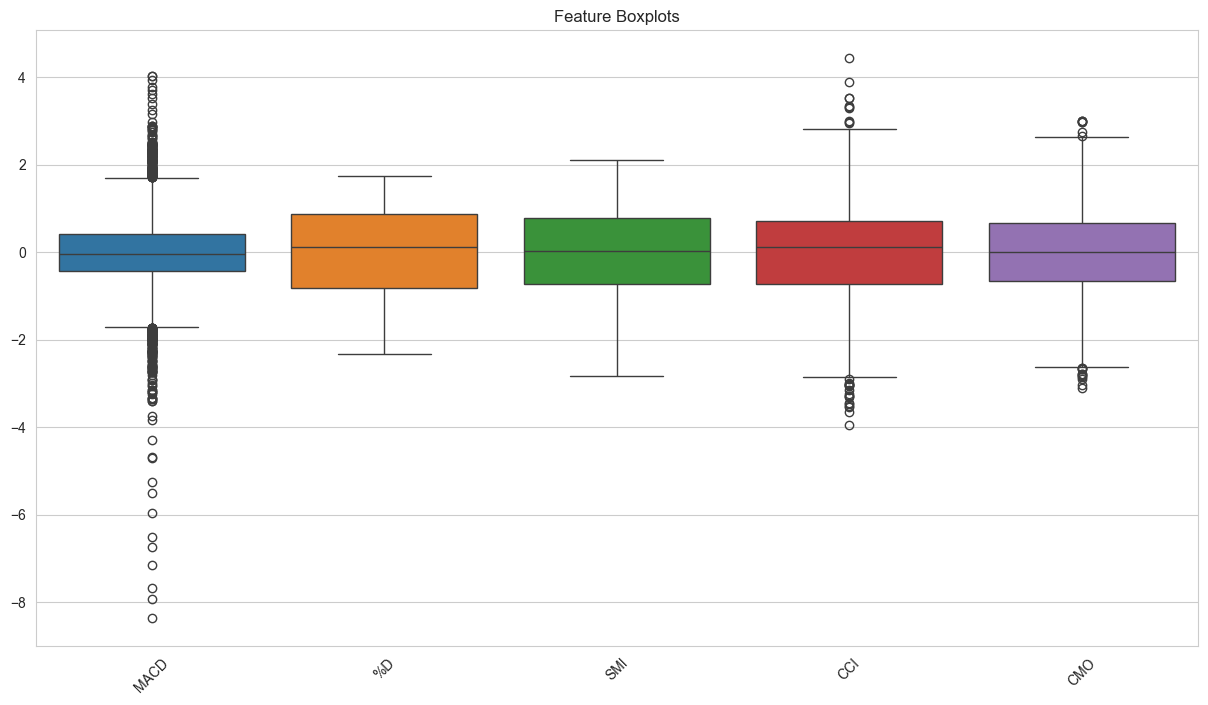

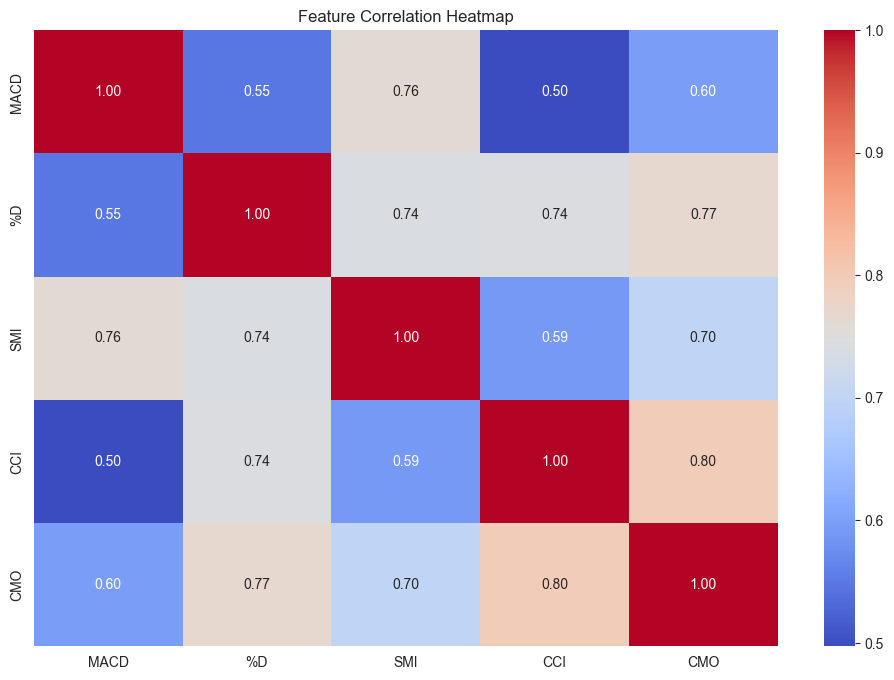

In [45]:
# Boxplot for feature distributions after normalization
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_features[selected_features])
plt.title('Feature Boxplots')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap after normalization
plt.figure(figsize=(12, 8))
sns.heatmap(df_features[selected_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Prepare the Data for Training and Testing

In [46]:
def create_sliding_window(X_data, y_data, window_size):
    """
    Create sliding window data for time series using separated features and targets.

    Parameters:
    - X_data (np.ndarray): Feature data of shape (n_samples, n_features).
    - y_data (np.ndarray): Target data of shape (n_samples,).
    - window_size (int): The size of the sliding window.

    Returns:
    - X (np.ndarray): Sliding window feature blocks of shape (n_samples - window_size, window_size, n_features).
    - y (np.ndarray): Corresponding targets of shape (n_samples - window_size,).
    """
    X, y = [], []
    for i in range(len(X_data) - window_size):
        X.append(X_data[i:i + window_size])
        y.append(y_data[i + window_size])
    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)



window_size = 5  # Define the size of the sliding window

# Create the sliding window data
X, y = create_sliding_window(df_features[selected_features], df_normalized['next_day_price_move'], window_size)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2874, 5, 5), y_train shape: (2874,)
X_test shape: (360, 5, 5), y_test shape: (360,)


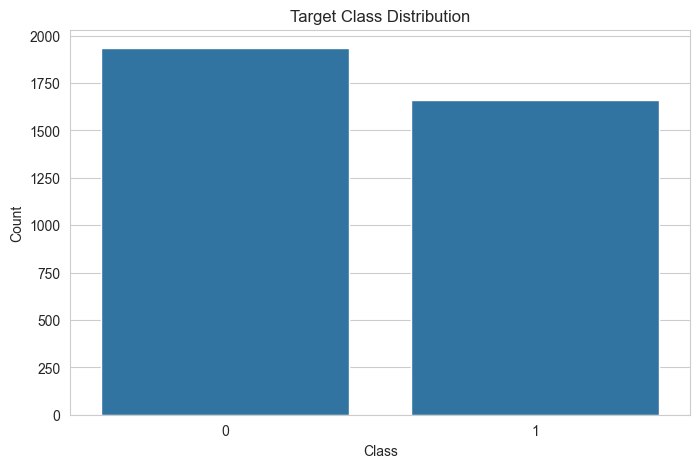

Class Distribution:
next_day_price_move
0    0.537799
1    0.462201
Name: proportion, dtype: float64


In [47]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x=df_normalized['next_day_price_move'])
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# print the class distribution
class_distribution = df_normalized['next_day_price_move'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

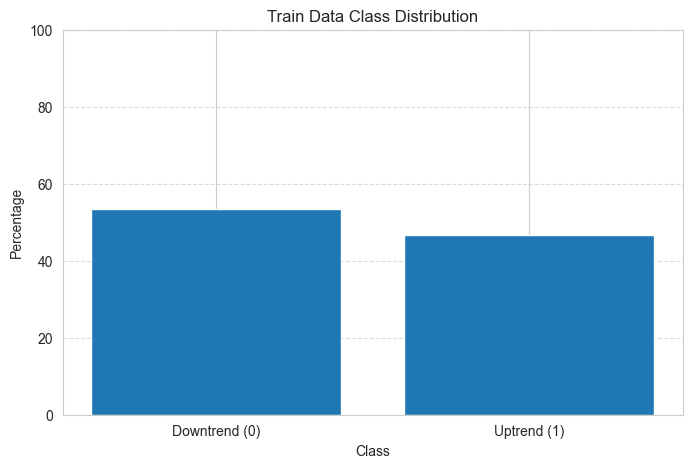

Train Data Class Distribution:
   Class  Count  Percentage
0    0.0   1536   53.444676
1    1.0   1338   46.555324


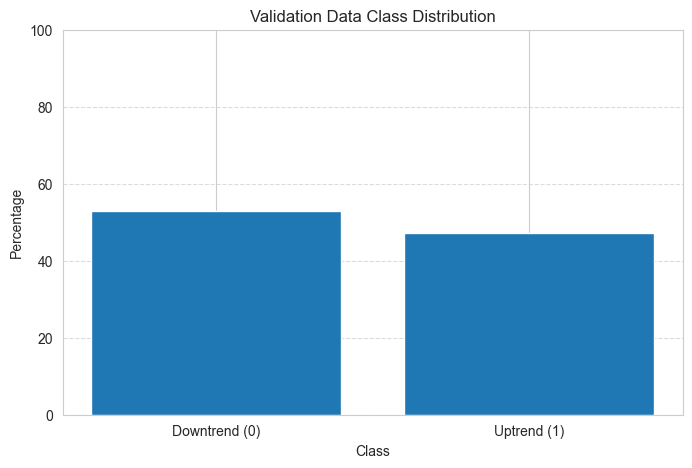

Validation Data Class Distribution:
   Class  Count  Percentage
0    0.0    190   52.924791
1    1.0    169   47.075209


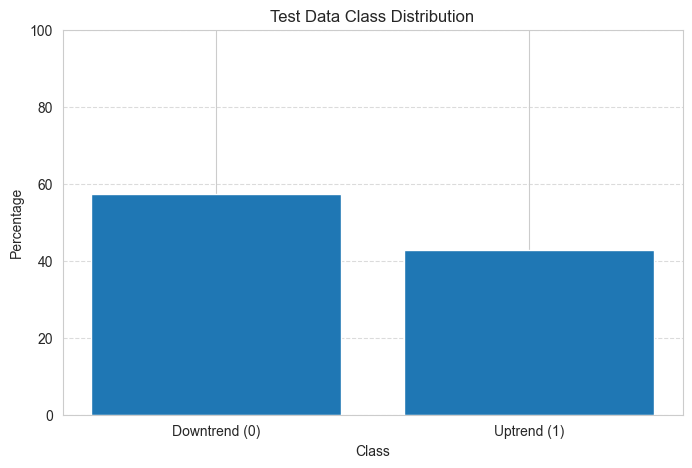

Test Data Class Distribution:
   Class  Count  Percentage
0    0.0    206   57.222222
1    1.0    154   42.777778


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Function to calculate and display class distribution
def plot_class_distribution(y_train, y_val, y_test):
    datasets = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
    class_labels = ['Downtrend (0)', 'Uptrend (1)']

    for name, y in datasets.items():
        # Calculate class distribution
        unique, counts = np.unique(y, return_counts=True)
        distribution = pd.DataFrame({'Class': unique, 'Count': counts})
        distribution['Percentage'] = (distribution['Count'] / len(y)) * 100

        # Plot the distribution
        plt.figure(figsize=(8, 5))
        plt.bar(distribution['Class'], distribution['Percentage'], tick_label=class_labels)
        plt.title(f'{name} Data Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Percentage')
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        # Print the distribution
        print(f"{name} Data Class Distribution:")
        print(distribution)


# Call the function
plot_class_distribution(y_train, y_val, y_test)

(5, 5)


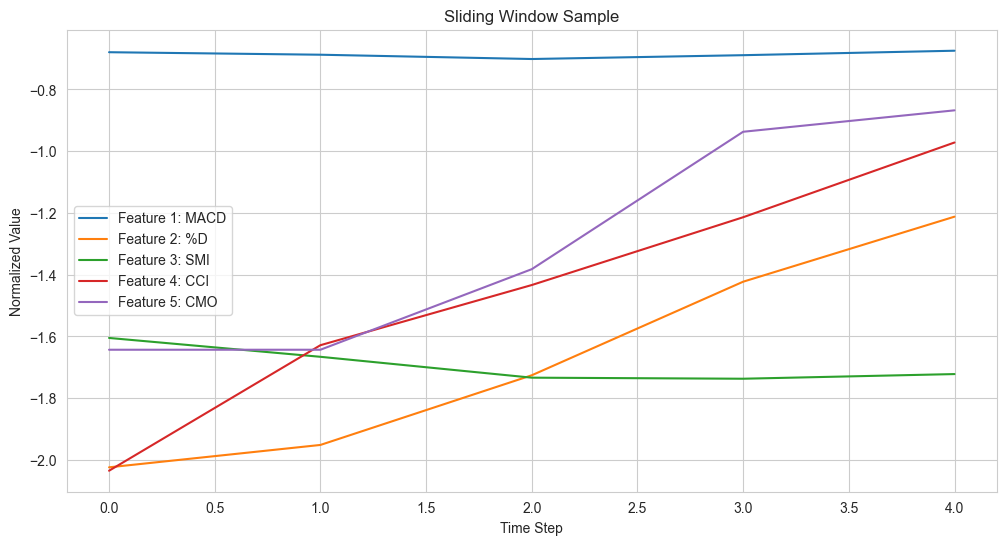

In [23]:
# Visualize a sample sliding window
sample_index = 0  # Change this to visualize different samples
sample_window = X_train[sample_index]

print(sample_window.shape)

plt.figure(figsize=(12, 6))
for i in range(sample_window.shape[1]):
    plt.plot(sample_window[:, i], label=f'Feature {i + 1}: {selected_features[i]}')
plt.title('Sliding Window Sample')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


# Train and Evaluate the Model with LSTM

In [24]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import numpy as np
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import f1_score

# Early stop
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Save best model
model_checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# Add F1 Score callback
class F1Callback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.validation_data[0])
        val_pred_labels = (val_pred > 0.5).astype(int)  # threshold for binary
        f1 = f1_score(self.validation_data[1], val_pred_labels)
        print(f" - val_f1_score: {f1:.4f}")
        logs['val_f1_score'] = f1


f1_callback = F1Callback(validation_data=(X_val, y_val))


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy, axis=-1)

    return loss


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
alpha = class_weights.tolist()

In [18]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

exp_name = "LSTM_binary_RFE-indicators_window5"

wandb.init(
    project="next_day_price_prediction_TESTING",
    name= exp_name,
    reinit="return_previous",
    config={
        "lstm_units_0": 128,
        "lstm_dropout_0": 0.3,

        "lstm_units_1": 64,
        "lstm_dropout_1": 0.3,

        # "lstm_units_2": 64,
        # "lstm_dropout_2": 0.3,

        "dense_units_0": 64,
        "dense_dropout_0": 0.2,
        "dense_activation_0": "relu",

        "use_batch_norm": False,
        "classification_threshold": 0.5,
        "feature_selection": "RFE",
        "model": exp_name,
        "selected_features": selected_features,
        "loss": "focal_loss(alpha=0.5, gamma=1)",
        # loss='binary_crossentropy',
        "class_weights": class_weights_dict,
        "optimizer": "Adam",
        "learning_rate": 0.000860707924021604,
        "epochs": 50,
        "batch_size": 16,
        "window_size": window_size,
    }
)

config = wandb.config

wandb: Currently logged in as: rivferd (rivferd-politeknik-negeri-malang) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [19]:
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, GRU, RNN, SimpleRNN
from keras.optimizers import Adam
from keras.regularizers import l2

# Define the LSTM model
model = Sequential()

# LSTM (first layer)
model.add(LSTM(config.lstm_units_0, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
if config.use_batch_norm:
    model.add(BatchNormalization())
model.add(Dropout(config.lstm_dropout_0))

# Middle LSTM Layer
model.add(LSTM(config.lstm_units_1, return_sequences=False))
if config.use_batch_norm:
    model.add(BatchNormalization())
model.add(Dropout(config.lstm_dropout_1))

# # Final LSTM Layer
# model.add(LSTM(config.lstm_units_2, return_sequences=False))
# if config.use_batch_norm:
#     model.add(BatchNormalization())
# model.add(Dropout(config.lstm_dropout_2))

# Dense layer
model.add(Dense(config.dense_units_0, activation=config.dense_activation_0))
if config.use_batch_norm:
    model.add(BatchNormalization())
model.add(Dropout(config.dense_dropout_0))

# model.add(Dense(config.dense_units_1, activation=config.dense_activation_1))
# if config.use_batch_norm:
#     model.add(BatchNormalization())
# model.add(Dropout(config.dense_dropout_1))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.summary()
model.compile(optimizer=Adam(learning_rate=config.learning_rate),
              loss=eval(config.loss),
              metrics=["accuracy", tf.keras.metrics.MeanSquaredError()]
              )

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config.epochs,
    batch_size=config.batch_size,
    class_weight=class_weights_dict,
    callbacks=[f1_callback, WandbMetricsLogger(), WandbModelCheckpoint("models", save_best_only=True, verbose=0)],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/50
12/12 [==============================] - 2s 6ms/step
 - val_f1_score: 0.5502


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 24s 85ms/step - loss: 0.1746 - accuracy: 0.4774 - mean_squared_error: 0.2509 - val_loss: 0.1738 - val_accuracy: 0.4763 - val_mean_squared_error: 0.2505 - val_f1_score: 0.5502
Epoch 2/50
12/12 [==============================] - 0s 4ms/step loss: 0.1738
 - val_f1_score: 0.4854


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 12s 65ms/step - loss: 0.1738 - accuracy: 0.4972 - mean_squared_error: 0.2504 - val_loss: 0.1732 - val_accuracy: 0.5097 - val_mean_squared_error: 0.2499 - val_f1_score: 0.4854
Epoch 3/50
12/12 [==============================] - 0s 4ms/step loss: 0.1739
 - val_f1_score: 0.5561


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 12s 68ms/step - loss: 0.1739 - accuracy: 0.4976 - mean_squared_error: 0.2505 - val_loss: 0.1731 - val_accuracy: 0.5376 - val_mean_squared_error: 0.2498 - val_f1_score: 0.5561
Epoch 4/50
12/12 [==============================] - 0s 4ms/step loss: 0.1733
 - val_f1_score: 0.4858


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 11s 60ms/step - loss: 0.1733 - accuracy: 0.5031 - mean_squared_error: 0.2499 - val_loss: 0.1730 - val_accuracy: 0.5460 - val_mean_squared_error: 0.2496 - val_f1_score: 0.4858
Epoch 5/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.3826


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 19ms/step - loss: 0.1736 - accuracy: 0.4990 - mean_squared_error: 0.2500 - val_loss: 0.1734 - val_accuracy: 0.4875 - val_mean_squared_error: 0.2500 - val_f1_score: 0.3826
Epoch 6/50
12/12 [==============================] - 0s 4ms/step loss: 0.1737
 - val_f1_score: 0.6018


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1737 - accuracy: 0.5038 - mean_squared_error: 0.2502 - val_loss: 0.1738 - val_accuracy: 0.5097 - val_mean_squared_error: 0.2505 - val_f1_score: 0.6018
Epoch 7/50
12/12 [==============================] - 0s 4ms/step loss: 0.1732
 - val_f1_score: 0.4467


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 12s 64ms/step - loss: 0.1732 - accuracy: 0.5164 - mean_squared_error: 0.2499 - val_loss: 0.1730 - val_accuracy: 0.5515 - val_mean_squared_error: 0.2495 - val_f1_score: 0.4467
Epoch 8/50
12/12 [==============================] - 0s 4ms/step loss: 0.1736
 - val_f1_score: 0.4858


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1737 - accuracy: 0.4951 - mean_squared_error: 0.2503 - val_loss: 0.1732 - val_accuracy: 0.5460 - val_mean_squared_error: 0.2498 - val_f1_score: 0.4858
Epoch 9/50
12/12 [==============================] - 0s 4ms/step loss: 0.1734
 - val_f1_score: 0.1845


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 11s 62ms/step - loss: 0.1734 - accuracy: 0.5188 - mean_squared_error: 0.2498 - val_loss: 0.1728 - val_accuracy: 0.5320 - val_mean_squared_error: 0.2494 - val_f1_score: 0.1845
Epoch 10/50
12/12 [==============================] - 0s 4ms/step loss: 0.1732
 - val_f1_score: 0.3602


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1732 - accuracy: 0.5164 - mean_squared_error: 0.2498 - val_loss: 0.1730 - val_accuracy: 0.5348 - val_mean_squared_error: 0.2494 - val_f1_score: 0.3602
Epoch 11/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.1932


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1731 - accuracy: 0.5174 - mean_squared_error: 0.2496 - val_loss: 0.1732 - val_accuracy: 0.5348 - val_mean_squared_error: 0.2497 - val_f1_score: 0.1932
Epoch 12/50
12/12 [==============================] - 0s 4ms/step loss: 0.1734
 - val_f1_score: 0.3498


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 11s 59ms/step - loss: 0.1734 - accuracy: 0.5181 - mean_squared_error: 0.2498 - val_loss: 0.1728 - val_accuracy: 0.5237 - val_mean_squared_error: 0.2492 - val_f1_score: 0.3498
Epoch 13/50
12/12 [==============================] - 0s 3ms/step loss: 0.1733
 - val_f1_score: 0.5215


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1733 - accuracy: 0.5198 - mean_squared_error: 0.2496 - val_loss: 0.1731 - val_accuracy: 0.5042 - val_mean_squared_error: 0.2498 - val_f1_score: 0.5215
Epoch 14/50
12/12 [==============================] - 0s 4ms/step loss: 0.1733
 - val_f1_score: 0.4164


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1733 - accuracy: 0.4923 - mean_squared_error: 0.2501 - val_loss: 0.1729 - val_accuracy: 0.5237 - val_mean_squared_error: 0.2495 - val_f1_score: 0.4164
Epoch 15/50
12/12 [==============================] - 0s 4ms/step loss: 0.1735
 - val_f1_score: 0.5354


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 15ms/step - loss: 0.1735 - accuracy: 0.5167 - mean_squared_error: 0.2499 - val_loss: 0.1736 - val_accuracy: 0.4875 - val_mean_squared_error: 0.2503 - val_f1_score: 0.5354
Epoch 16/50
12/12 [==============================] - 0s 6ms/step
 - val_f1_score: 0.4126


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 19ms/step - loss: 0.1732 - accuracy: 0.5118 - mean_squared_error: 0.2497 - val_loss: 0.1729 - val_accuracy: 0.5320 - val_mean_squared_error: 0.2495 - val_f1_score: 0.4126
Epoch 17/50
12/12 [==============================] - 0s 4ms/step loss: 0.1730
 - val_f1_score: 0.5622


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1730 - accuracy: 0.5257 - mean_squared_error: 0.2495 - val_loss: 0.1752 - val_accuracy: 0.5097 - val_mean_squared_error: 0.2513 - val_f1_score: 0.5622
Epoch 18/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.4615


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 11s 59ms/step - loss: 0.1731 - accuracy: 0.5216 - mean_squared_error: 0.2498 - val_loss: 0.1726 - val_accuracy: 0.5320 - val_mean_squared_error: 0.2491 - val_f1_score: 0.4615
Epoch 19/50
12/12 [==============================] - 0s 6ms/step
 - val_f1_score: 0.4812


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 19ms/step - loss: 0.1727 - accuracy: 0.5188 - mean_squared_error: 0.2493 - val_loss: 0.1732 - val_accuracy: 0.5014 - val_mean_squared_error: 0.2498 - val_f1_score: 0.4812
Epoch 20/50
12/12 [==============================] - 0s 4ms/step loss: 0.1731
 - val_f1_score: 0.3838


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1731 - accuracy: 0.5160 - mean_squared_error: 0.2494 - val_loss: 0.1730 - val_accuracy: 0.5348 - val_mean_squared_error: 0.2494 - val_f1_score: 0.3838
Epoch 21/50
12/12 [==============================] - 0s 4ms/step loss: 0.1731
 - val_f1_score: 0.2783


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1731 - accuracy: 0.5132 - mean_squared_error: 0.2496 - val_loss: 0.1727 - val_accuracy: 0.5376 - val_mean_squared_error: 0.2490 - val_f1_score: 0.2783
Epoch 22/50
12/12 [==============================] - 0s 4ms/step loss: 0.1730
 - val_f1_score: 0.4170


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1730 - accuracy: 0.5296 - mean_squared_error: 0.2493 - val_loss: 0.1727 - val_accuracy: 0.5404 - val_mean_squared_error: 0.2492 - val_f1_score: 0.4170
Epoch 23/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.4777


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 11s 63ms/step - loss: 0.1725 - accuracy: 0.5334 - mean_squared_error: 0.2487 - val_loss: 0.1723 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2480 - val_f1_score: 0.4777
Epoch 24/50
12/12 [==============================] - 0s 4ms/step loss: 0.1728
 - val_f1_score: 0.3374


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 11s 61ms/step - loss: 0.1729 - accuracy: 0.5317 - mean_squared_error: 0.2490 - val_loss: 0.1717 - val_accuracy: 0.5515 - val_mean_squared_error: 0.2472 - val_f1_score: 0.3374
Epoch 25/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.4825


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1725 - accuracy: 0.5278 - mean_squared_error: 0.2482 - val_loss: 0.1723 - val_accuracy: 0.5460 - val_mean_squared_error: 0.2485 - val_f1_score: 0.4825
Epoch 26/50
12/12 [==============================] - 0s 4ms/step loss: 0.1728
 - val_f1_score: 0.4083


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1727 - accuracy: 0.5160 - mean_squared_error: 0.2489 - val_loss: 0.1723 - val_accuracy: 0.5237 - val_mean_squared_error: 0.2485 - val_f1_score: 0.4083
Epoch 27/50
12/12 [==============================] - 0s 4ms/step loss: 0.1727
 - val_f1_score: 0.3643


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1727 - accuracy: 0.5386 - mean_squared_error: 0.2488 - val_loss: 0.1725 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2486 - val_f1_score: 0.3643
Epoch 28/50
12/12 [==============================] - 0s 4ms/step loss: 0.1730
 - val_f1_score: 0.4408


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 18ms/step - loss: 0.1730 - accuracy: 0.5289 - mean_squared_error: 0.2492 - val_loss: 0.1721 - val_accuracy: 0.5265 - val_mean_squared_error: 0.2483 - val_f1_score: 0.4408
Epoch 29/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.5416


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 18ms/step - loss: 0.1721 - accuracy: 0.5393 - mean_squared_error: 0.2482 - val_loss: 0.1738 - val_accuracy: 0.5237 - val_mean_squared_error: 0.2493 - val_f1_score: 0.5416
Epoch 30/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.3866


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1725 - accuracy: 0.5282 - mean_squared_error: 0.2485 - val_loss: 0.1724 - val_accuracy: 0.5404 - val_mean_squared_error: 0.2485 - val_f1_score: 0.3866
Epoch 31/50
12/12 [==============================] - 0s 7ms/step
 - val_f1_score: 0.4384


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1726 - accuracy: 0.5282 - mean_squared_error: 0.2485 - val_loss: 0.1721 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2482 - val_f1_score: 0.4384
Epoch 32/50
12/12 [==============================] - 0s 5ms/step
 - val_f1_score: 0.5088


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 18ms/step - loss: 0.1722 - accuracy: 0.5379 - mean_squared_error: 0.2481 - val_loss: 0.1728 - val_accuracy: 0.5320 - val_mean_squared_error: 0.2486 - val_f1_score: 0.5088
Epoch 33/50
12/12 [==============================] - 0s 6ms/step
 - val_f1_score: 0.4682


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 4s 20ms/step - loss: 0.1720 - accuracy: 0.5386 - mean_squared_error: 0.2479 - val_loss: 0.1723 - val_accuracy: 0.5571 - val_mean_squared_error: 0.2481 - val_f1_score: 0.4682
Epoch 34/50
12/12 [==============================] - 0s 4ms/step loss: 0.1723
 - val_f1_score: 0.4086


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1723 - accuracy: 0.5351 - mean_squared_error: 0.2484 - val_loss: 0.1725 - val_accuracy: 0.5404 - val_mean_squared_error: 0.2484 - val_f1_score: 0.4086
Epoch 35/50
12/12 [==============================] - 0s 4ms/step loss: 0.1721
 - val_f1_score: 0.4922


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1721 - accuracy: 0.5358 - mean_squared_error: 0.2479 - val_loss: 0.1721 - val_accuracy: 0.5460 - val_mean_squared_error: 0.2473 - val_f1_score: 0.4922
Epoch 36/50
12/12 [==============================] - 0s 6ms/step
 - val_f1_score: 0.4474


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1723 - accuracy: 0.5407 - mean_squared_error: 0.2477 - val_loss: 0.1730 - val_accuracy: 0.5320 - val_mean_squared_error: 0.2487 - val_f1_score: 0.4474
Epoch 37/50
12/12 [==============================] - 0s 4ms/step loss: 0.1716
 - val_f1_score: 0.5543


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1717 - accuracy: 0.5407 - mean_squared_error: 0.2473 - val_loss: 0.1737 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2485 - val_f1_score: 0.5543
Epoch 38/50
12/12 [==============================] - 0s 4ms/step loss: 0.1720
 - val_f1_score: 0.4783


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 17ms/step - loss: 0.1719 - accuracy: 0.5334 - mean_squared_error: 0.2478 - val_loss: 0.1727 - val_accuracy: 0.5320 - val_mean_squared_error: 0.2485 - val_f1_score: 0.4783
Epoch 39/50
12/12 [==============================] - 0s 4ms/step loss: 0.1717
 - val_f1_score: 0.5073


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 18ms/step - loss: 0.1717 - accuracy: 0.5463 - mean_squared_error: 0.2469 - val_loss: 0.1729 - val_accuracy: 0.5292 - val_mean_squared_error: 0.2489 - val_f1_score: 0.5073
Epoch 40/50
12/12 [==============================] - 0s 6ms/step
 - val_f1_score: 0.4765


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 4s 20ms/step - loss: 0.1720 - accuracy: 0.5296 - mean_squared_error: 0.2477 - val_loss: 0.1721 - val_accuracy: 0.5348 - val_mean_squared_error: 0.2474 - val_f1_score: 0.4765
Epoch 41/50
12/12 [==============================] - 0s 4ms/step loss: 0.1715
 - val_f1_score: 0.4481


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1715 - accuracy: 0.5463 - mean_squared_error: 0.2469 - val_loss: 0.1726 - val_accuracy: 0.5265 - val_mean_squared_error: 0.2477 - val_f1_score: 0.4481
Epoch 42/50
12/12 [==============================] - 0s 4ms/step loss: 0.1714
 - val_f1_score: 0.5000


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 13ms/step - loss: 0.1715 - accuracy: 0.5393 - mean_squared_error: 0.2470 - val_loss: 0.1727 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2479 - val_f1_score: 0.5000
Epoch 43/50
12/12 [==============================] - 0s 3ms/step loss: 0.1715
 - val_f1_score: 0.5314


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 13ms/step - loss: 0.1714 - accuracy: 0.5296 - mean_squared_error: 0.2467 - val_loss: 0.1721 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2479 - val_f1_score: 0.5314
Epoch 44/50
12/12 [==============================] - 0s 3ms/step loss: 0.1714
 - val_f1_score: 0.5146


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 13ms/step - loss: 0.1712 - accuracy: 0.5299 - mean_squared_error: 0.2466 - val_loss: 0.1730 - val_accuracy: 0.5376 - val_mean_squared_error: 0.2485 - val_f1_score: 0.5146
Epoch 45/50
12/12 [==============================] - 0s 3ms/step loss: 0.1712
 - val_f1_score: 0.5128


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 14ms/step - loss: 0.1712 - accuracy: 0.5421 - mean_squared_error: 0.2465 - val_loss: 0.1736 - val_accuracy: 0.5237 - val_mean_squared_error: 0.2489 - val_f1_score: 0.5128
Epoch 46/50
12/12 [==============================] - 0s 3ms/step loss: 0.1708
 - val_f1_score: 0.5148


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 12ms/step - loss: 0.1708 - accuracy: 0.5536 - mean_squared_error: 0.2456 - val_loss: 0.1747 - val_accuracy: 0.5432 - val_mean_squared_error: 0.2489 - val_f1_score: 0.5148
Epoch 47/50
12/12 [==============================] - 0s 3ms/step loss: 0.1701
 - val_f1_score: 0.4214


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 11ms/step - loss: 0.1702 - accuracy: 0.5494 - mean_squared_error: 0.2449 - val_loss: 0.1744 - val_accuracy: 0.5153 - val_mean_squared_error: 0.2493 - val_f1_score: 0.4214
Epoch 48/50
12/12 [==============================] - 0s 4ms/step loss: 0.1702
 - val_f1_score: 0.5085


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 12ms/step - loss: 0.1702 - accuracy: 0.5560 - mean_squared_error: 0.2444 - val_loss: 0.1742 - val_accuracy: 0.5153 - val_mean_squared_error: 0.2496 - val_f1_score: 0.5085
Epoch 49/50
12/12 [==============================] - 0s 4ms/step loss: 0.1704
 - val_f1_score: 0.5060


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 3s 16ms/step - loss: 0.1703 - accuracy: 0.5543 - mean_squared_error: 0.2450 - val_loss: 0.1747 - val_accuracy: 0.5376 - val_mean_squared_error: 0.2494 - val_f1_score: 0.5060
Epoch 50/50
12/12 [==============================] - 0s 7ms/step
 - val_f1_score: 0.4582


wandb: Adding directory to artifact (.\models)... Done. 0.0s


180/180 [==============================] - 2s 12ms/step - loss: 0.1704 - accuracy: 0.5491 - mean_squared_error: 0.2448 - val_loss: 0.1762 - val_accuracy: 0.5125 - val_mean_squared_error: 0.2511 - val_f1_score: 0.4582


# Evaluate the model

In [20]:
loss, accuracy, MSE = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

preds = model.predict(X_test)
print("Predicted class counts:", np.bincount((preds > config.classification_threshold).astype(int).flatten()))

12/12 [==============================] - 0s 9ms/step - loss: 0.1715 - accuracy: 0.5389 - mean_squared_error: 0.2463
Test Accuracy: 0.54
12/12 [==============================] - 0s 6ms/step
Predicted class counts: [184 176]


12/12 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

        Down       0.61      0.54      0.57       206
          Up       0.47      0.53      0.50       154

    accuracy                           0.54       360
   macro avg       0.54      0.54      0.54       360
weighted avg       0.55      0.54      0.54       360



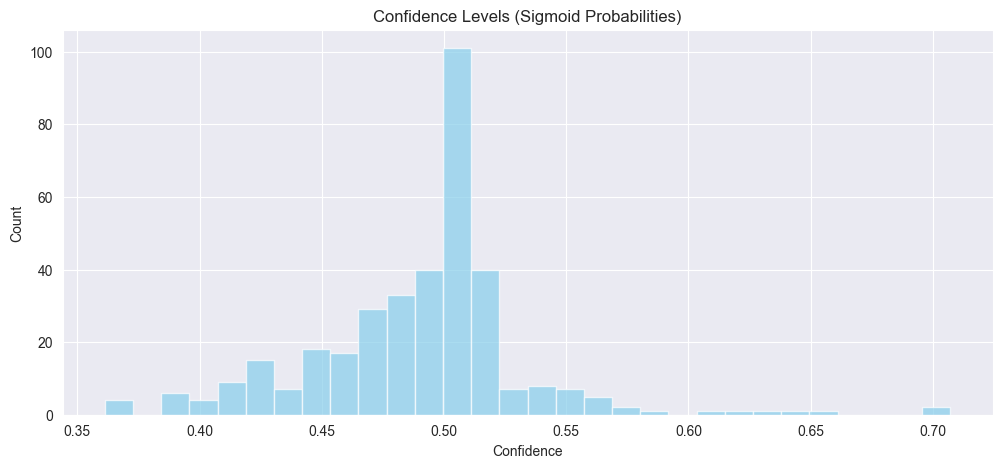

In [21]:
# Predict probabilities for the test set
pred_probs = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = (pred_probs > config.classification_threshold).astype(int).flatten()

# Compare predictions with actual values
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

# Visualize probability distributions
plt.figure(figsize=(12, 5))
plt.hist(pred_probs, bins=30, alpha=0.7, color='skyblue')
plt.title("Confidence Levels (Sigmoid Probabilities)")
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.grid(True)
plt.show()

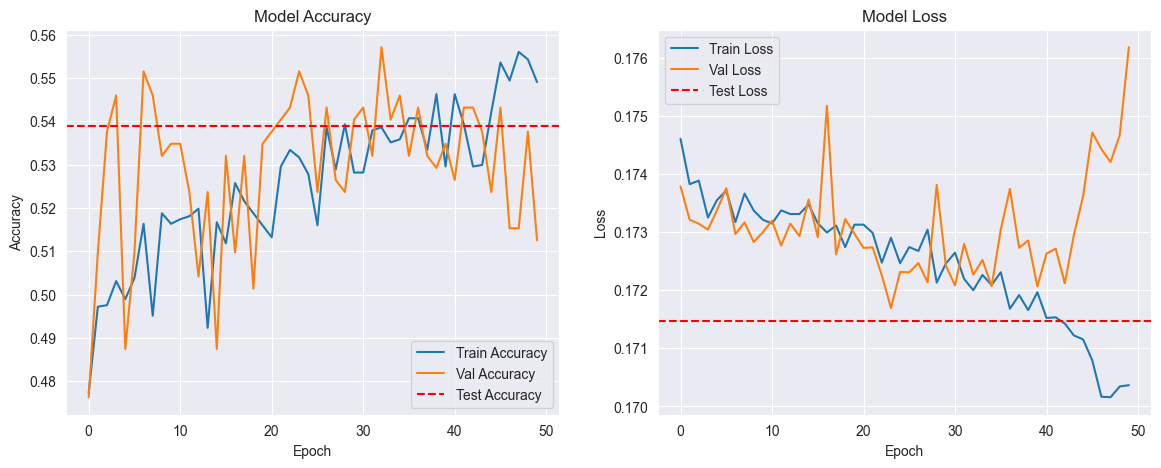

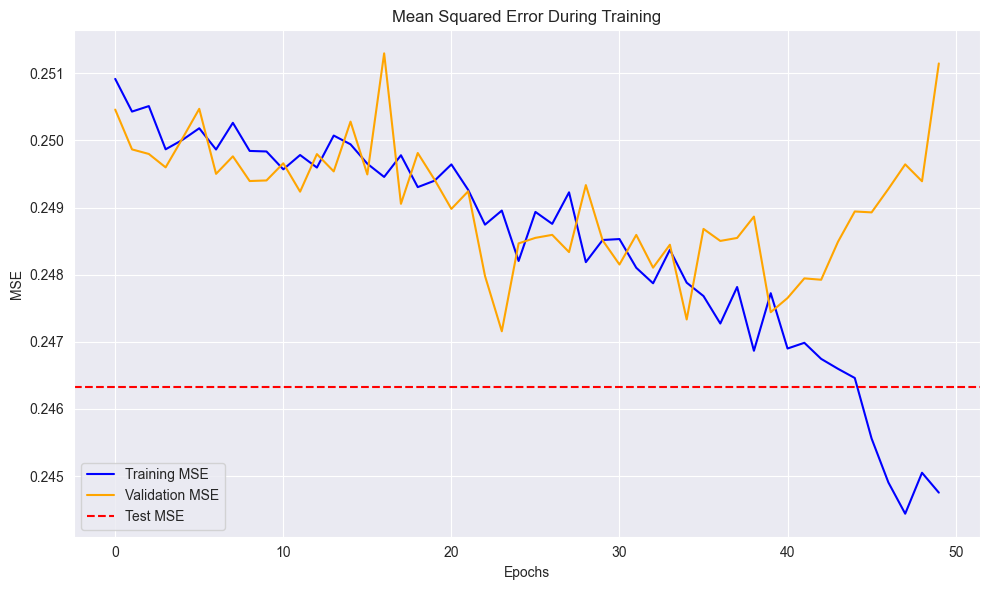

In [22]:
# Assuming `test_loss` and `test_accuracy` are calculated after model evaluation
test_loss, test_accuracy, test_MSE = model.evaluate(X_test, y_test, verbose=0)

# Plot training, validation, and test accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the MSE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training MSE', color='blue')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE', color='orange')
plt.axhline(y=test_MSE, color='r', linestyle='--', label='Test MSE')
plt.title('Mean Squared Error During Training')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

12/12 [==============================] - 1s 6ms/step


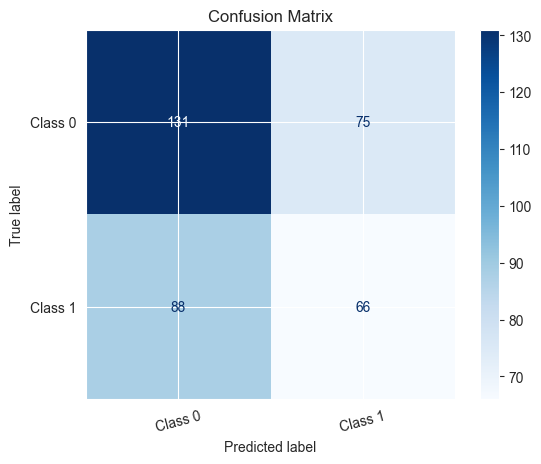

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > config.classification_threshold).astype(int).flatten()

# Determine unique classes in y_test
unique_labels = sorted(set(y_test))

# Dynamically set labels based on classification type
if len(unique_labels) == 2:  # Binary classification
    labels = ['Class 0', 'Class 1']
else:  # Multi-class classification
    labels = [f'Class {int(label)}' for label in unique_labels]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=15)
plt.show()

# Save models

In [24]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average=None)

# Log each class's metrics to wandb
for i, (p, r, f, s) in enumerate(zip(precision, recall, fscore, support)):
    wandb.log({
        f'precision_class_{i}': p,
        f'recall_class_{i}': r,
        f'support_class_{i}': s,
        f'f1_class_{i}': f,
    })

report = classification_report(y_test, y_pred, target_names=["Down", "Up"], output_dict=True)

# Log desired metrics to W&B
wandb.log({
    "accuracy": report["accuracy"],
    "f1_weighted": report["weighted avg"]["f1-score"],
    "f1_macro": report["macro avg"]["f1-score"],
    "precision_weighted": report["weighted avg"]["precision"],
    "recall_weighted": report["weighted avg"]["recall"]
})

In [25]:
model.save('keras_models-percobaan/latest/stock_trend_predictor.keras')
wandb.log({"test_loss": loss, "test_accuracy": accuracy})
wandb.finish()

accuracy,▁
epoch/accuracy,▁▃▃▃▃▃▅▄▅▅▂▅▄▅▅▄▄▆▆▆▄▆▆▇▆▆▆▆▆▇▆▇▇▇▆▇█▇█▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▇▆▆▆▆▆▆▅▆▆▆▅▅▅▅▅▆▄▅▄▄▄▄▃▃▄▃▃▃▃▂▁▁▁
epoch/mean_squared_error,█▇█▇▇▇▇▇▇▇▇▇▇▆▇▆▇▆▆▅▆▆▅▅▅▅▅▅▅▄▄▅▄▄▃▃▂▂▁▁
epoch/val_accuracy,▁▄▆▇▂█▇▆▆▆▃▅▂▆▄▃▆▆▇▇▇▅▇▅▅▇▆█▇▇▆▆▆▅▇▆▅▇▄▄
epoch/val_f1_score,█▇█▇▅▆▇▁▄▁▇▅█▅█▆▅▃▆▄▅▄▆█▅▆▅▇▆█▇▆▆▇▇▇▇▅▇▆
epoch/val_loss,▄▃▃▃▄▃▃▃▃▃▃▃▄▃▂▃▃▃▂▁▂▂▂▄▂▃▂▂▃▄▃▂▂▃▂▄▆▅▅█
epoch/val_mean_squared_error,▇▆▅▅▆▅▅▅▅▅▅▅▆▅█▅▅▅▂▁▃▃▃▅▃▃▃▃▁▄▃▄▁▂▂▃▄▄▅█
f1_class_0,▁


# ANOTHER TESTING

In [192]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

In [32]:
import wandb
run = wandb.init()
artifact = run.use_artifact('rivferd-politeknik-negeri-malang/next_day_price_prediction_TESTING/run_cl70sgdb_model:v7', type='model')
artifact_dir = artifact.download()

wandb:   4 of 4 files downloaded.  


12/12 [==============================] - 0s 5ms/step


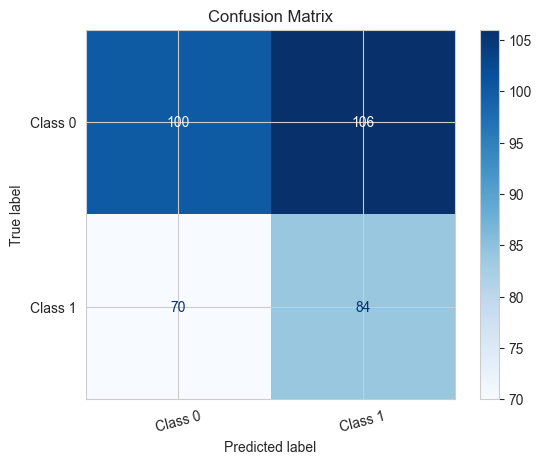

In [33]:
# print ulang confusion matrix
import tensorflow as tf
model = tf.keras.models.load_model(artifact_dir, custom_objects={"loss": focal_loss(alpha=0.5, gamma=1.0)})

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Determine unique classes in y_test
unique_labels = sorted(set(y_test))

# Dynamically set labels based on classification type
if len(unique_labels) == 2:  # Binary classification
    labels = ['Class 0', 'Class 1']
else:  # Multi-class classification
    labels = [f'Class {int(label)}' for label in unique_labels]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=15)
plt.show()

In [202]:
# def predict_stock_trend(stock_code: str, date: str):
#     # Convert date
#     end_ts = convert_to_unix_timestamp(date)
#     start_ts = convert_to_unix_timestamp("2020-01-01")  # or go 100 days back
#
#     # Fetch data
#     stock_url = f"https://query2.finance.yahoo.com/v8/finance/chart/{stock_code}?period1={start_ts}&period2={end_ts}&interval=1d"
#     headers = {
#         "Content-Type": "application/json",
#         "User-Agent": "Mozilla/5.0"
#     }
#     r = requests.get(stock_url, headers=headers)
#     stock_data = StockResponse.from_json(r.json()).stock_data
#
#     # for testing only, print the last date that got from the api
#     print('Last date:')
#     print(stock_data[-1].date)
#
#     df = StockResponse(stock_data).to_dataframe()
#
#     # Compute indicators
#     df = compute_and_add_indicators(stock_data, df)
#
#     # Drop non-feature columns
#     feature_df = df.drop(columns=["date", "next_day_price_move"], errors="ignore")
#
#     # Only use feature that saved on "selected_features.txt"
#     selected_features = []
#     with open("keras_models-percobaan/selected_features.txt", "r") as f:
#         for line in f:
#             selected_features.append(line.strip())
#     feature_df = feature_df[selected_features]
#
#     # Get last window (e.g., last 60 days)
#     window_size = X_train.shape[1]  # reuse your training window size
#     if len(feature_df) < window_size:
#         print("Not enough data to predict")
#         return
#
#     x_input = feature_df[-window_size:].values
#     x_input = x_input.reshape((1, x_input.shape[0], x_input.shape[1]))
#
#     # Ensure x_input does not contain decimal.Decimal objects by converting them to float
#     if isinstance(x_input, np.ndarray):
#         x_input = x_input.astype(float)  # Convert the entire NumPy array to float
#     else:
#         # For iterables other than NumPy arrays
#         x_input = np.array([float(value) for value in x_input])
#
#
#     # Load model
#     # model = load_model("stock_trend_predictor.h5", custom_objects={'focal_loss': focal_loss})
#
#     # Predict
#     pred = model.predict(x_input)
#     predicted_class = (pred > config.classification_threshold).astype(int).flatten()
#
#     label_map = {0: "Downtrend", 1: "Uptrend"}
#     print(f'pred: {pred}')
#     print(f'predicted_class: {predicted_class}')
#     print(f'label map: {label_map}')
#
#     # Convert predicted_class to an integer
#     predicted_class_int = int(predicted_class[0])
#     print(f"Prediction for {stock_code} on {date}: {label_map[predicted_class_int]}")
#     return predicted_class_int

In [203]:
# from datetime import datetime, timedelta
# import numpy as np
# import pandas as pd
# import requests
# import random
#
# # === MAIN LOOP ===
# total_tests = 50  # Change this to 50 if you want
# correct = 0
#
# for i in range(total_tests):
#     stock_code = random.choice(["BMRI.JK", "BBNI.JK"])
#     today = datetime.now()
#     end_date = today - timedelta(days=2)
#     start_date = end_date - timedelta(days=1000)
#
#     url = f"https://query2.finance.yahoo.com/v8/finance/chart/{stock_code}?" \
#           f"period1={int(start_date.timestamp())}&period2={int(end_date.timestamp())}&interval=1d"
#     headers = {
#         "Content-Type": "application/json",
#         "User-Agent": "Mozilla/5.0"
#     }
#
#     r = requests.get(url, headers=headers)
#     stock_data = StockResponse.from_json(r.json())
#     df = stock_data.to_dataframe().dropna().reset_index(drop=True)
#
#     if len(df) < 62:
#         continue  # Not enough data to predict
#
#     random_index = random.randint(60, len(df) - 2)
#     last_date = df.loc[random_index - 1, "date"]
#     actual_date = df.loc[random_index, "date"]
#     close_last_date = df.loc[random_index - 1, "close"]
#     close_actual = df.loc[random_index, "close"]
#     price_change = close_actual - close_last_date
#
#     # Binary classification: 0 = Downtrend, 1 = Uptrend
#     actual_class = 1 if price_change > 0 else 0
#
#     # Predict using your model
#     predicted_class = predict_stock_trend(stock_code, actual_date.strftime("%Y-%m-%d"))
#
#     label_map = {0: "Downtrend", 1: "Uptrend"}
#     print(f"Test #{i+1}")
#     print(f"Stock Code       : {stock_code}")
#     print(f"Last Known Date  : {last_date.strftime('%Y-%m-%d')}")
#     print(f"Prediction Date  : {actual_date.strftime('%Y-%m-%d')}")
#     print(f"Close Last Date  : {close_last_date:.2f}")
#     print(f"Close Actual     : {close_actual:.2f}")
#     print(f"Actual Movement  : {label_map[actual_class]}")
#     print(f"Predicted        : {label_map[predicted_class]}")
#     print(f"{'✅ Correct' if predicted_class == actual_class else '❌ Incorrect'}")
#     print("-" * 50)
#
#     if predicted_class == actual_class:
#         correct += 1
#
# print(f"\n✅ Prediction Accuracy over {total_tests} tests: {correct / total_tests:.2%}")

Last date:
2023-12-19 09:00:00
1/1 [==============================] - 1s 549ms/step
pred: [[0.47065794]]
predicted_class: [0]
label map: {0: 'Downtrend', 1: 'Uptrend'}
Prediction for BBNI.JK on 2023-12-19: Downtrend
Test #1
Stock Code       : BBNI.JK
Last Known Date  : 2023-12-18
Prediction Date  : 2023-12-19
Close Last Date  : 5200.00
Close Actual     : 5200.00
Actual Movement  : Downtrend
Predicted        : Downtrend
✅ Correct
--------------------------------------------------
Last date:
2023-06-23 09:00:00
1/1 [==============================] - 0s 24ms/step
pred: [[0.34920195]]
predicted_class: [0]
label map: {0: 'Downtrend', 1: 'Uptrend'}
Prediction for BMRI.JK on 2023-06-23: Downtrend
Test #2
Stock Code       : BMRI.JK
Last Known Date  : 2023-06-22
Prediction Date  : 2023-06-23
Close Last Date  : 5075.00
Close Actual     : 5075.00
Actual Movement  : Downtrend
Predicted        : Downtrend
✅ Correct
--------------------------------------------------
Last date:
2024-01-17 09:00:00
1/

In [195]:
# import keras_tuner as kt
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
#
# def build_model(hp):
#     model = Sequential()
#
#     # LSTM Layer
#     model.add(LSTM(
#         units=hp.Choice("lstm_units", values=[64, 128, 256]),
#         return_sequences=False,
#         input_shape=(X_train.shape[1], X_train.shape[2])
#     ))
#     model.add(BatchNormalization())
#     model.add(Dropout(hp.Choice("dropout_rate", values=[0.2, 0.3, 0.4])))
#
#     # Dense Layer
#     model.add(Dense(
#         units=hp.Choice("dense_units", values=[32, 64, 128]),
#         activation="relu"
#     ))
#     model.add(BatchNormalization())
#
#     # Output Layer
#     model.add(Dense(1, activation="sigmoid"))
#
#     # Compile
#     model.compile(
#         optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
#         loss="binary_crossentropy",
#         metrics=["accuracy"]
#     )
#
#     return model
#
# # Tuner setup
# tuner = kt.RandomSearch(
#     build_model,
#     objective="val_accuracy",  # or use 'val_loss' if more stable
#     max_trials=10,
#     executions_per_trial=1,
#     overwrite=True,
#     directory="tuner_results",
#     project_name="binary_lstm_tune"
# )
#
# # Early stopping
# early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
#
# # Try all class weight options manually in loop
# class_weight_options = [
#     {0: 0.5, 1: 1.0},
#     {0: 0.6, 1: 1.0},
#     {0: 0.7, 1: 1.0},
# ]
#
# # Start tuning
# for i, cw in enumerate(class_weight_options):
#     print(f"🔄 Trying class weight set {i+1}: {cw}")
#     tuner.search(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=30,
#         batch_size=32,
#         class_weight=cw,
#         callbacks=[early_stopping],
#         verbose=1
#     )
#
# # Retrieve the best model
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
#
# # Evaluate on test data
# loss, accuracy = best_model.evaluate(X_test, y_test)
# print(f"\n✅ Best Test Accuracy: {accuracy:.4f}")
# print(f"🔧 Best Hyperparameters: {best_hyperparams.values}")


# Hyperparameter Tuning


In [196]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.utils import compute_class_weight
# from sklearn.metrics import f1_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping
# import keras_tuner as kt
#
# # === STEP 1: Sliding window ===
# def create_sliding_window(features, labels, window_size):
#     X, y = [], []
#     for i in range(len(features) - window_size):
#         X.append(features[i:i + window_size])
#         y.append(labels[i + window_size])
#     return np.array(X), np.array(y)
#
# # === STEP 2: Focal loss ===
# def focal_loss(alpha=0.25, gamma=2.0):
#     def loss(y_true, y_pred):
#         y_true = K.cast(y_true, K.floatx())
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
#         cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
#         weight = alpha * y_true * K.pow(1 - y_pred, gamma) + \
#                  (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
#         return K.mean(weight * cross_entropy)
#     return loss
#
# # === STEP 3: Model builder ===
# def build_model(hp):
#     model = Sequential()
#
#     # LSTM Layers
#     lstm_layers = hp.Int("lstm_layers", 1, 3)
#     for i in range(lstm_layers):
#         return_seq = i < lstm_layers - 1
#         model.add(LSTM(
#             units=hp.Choice(f"lstm_units_{i}", [64, 128, 256]),
#             return_sequences=return_seq,
#             input_shape=(X_train.shape[1], X_train.shape[2])
#         ))
#         if hp.Boolean(f"use_bn_{i}"):
#             model.add(BatchNormalization())
#         model.add(Dropout(hp.Choice(f"lstm_dropout_{i}", [0.2, 0.3, 0.4])))
#
#     # Dense Layers
#     dense_layers = hp.Int("dense_layers", 1, 3)
#     for i in range(dense_layers):
#         model.add(Dense(
#             units=hp.Choice(f"dense_units_{i}", [32, 64, 128]), activation='relu'))
#         if hp.Boolean(f"use_bn_dense_{i}"):
#             model.add(BatchNormalization())
#
#     model.add(Dense(1, activation='sigmoid'))
#
#     # Focal Loss parameters
#     alpha = hp.Choice("focal_alpha", [0.25, 0.5, 0.75])
#     gamma = hp.Choice("focal_gamma", [1.0, 2.0, 3.0])
#
#     model.compile(
#         optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
#         loss=focal_loss(alpha=alpha, gamma=gamma),
#         metrics=['accuracy']
#     )
#     return model
#
# # === STEP 4: Data prep ===
# features = df.drop(columns=["date", "next_day_price_move"]).values
# labels = df["next_day_price_move"].values
#
# scaler = StandardScaler()
# features = scaler.fit_transform(features)
#
# # Loop over multiple window sizes
# for window_size in [30, 60, 90]:
#     print(f"\n🪟 Trying window size: {window_size}")
#     X, y = create_sliding_window(features, labels, window_size)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
#
#     tuner = kt.RandomSearch(
#         build_model,
#         objective="val_accuracy",
#         max_trials=10,
#         executions_per_trial=1,
#         overwrite=True,
#         directory="tuner_results",
#         project_name=f"lstm_tune_window{window_size}"
#     )
#
#     for batch_size in [16, 32, 64]:
#         tuner.search(
#             X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=30,
#             batch_size=batch_size,
#             callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
#             verbose=1
#         )
#
#     best_model = tuner.get_best_models(1)[0]
#     probs = best_model.predict(X_test).flatten()
#
#     thresholds = np.linspace(0.1, 0.9, 50)
#     f1s = [f1_score(y_test, probs > t) for t in thresholds]
#     best_thresh = thresholds[np.argmax(f1s)]
#     print(f"\n✅ Best threshold for window {window_size}: {best_thresh:.2f}")
#
#     final_preds = (probs > best_thresh).astype(int)
#     final_f1 = f1_score(y_test, final_preds)
#     print(f"🎯 Final F1 Score: {final_f1:.4f}")


In [197]:
# best_model = tuner.get_best_models(1)[0]
# best_hp = tuner.get_best_hyperparameters(1)[0]
#
# probs = best_model.predict(X_test).flatten()
# thresholds = np.linspace(0.1, 0.9, 50)
# f1s = [f1_score(y_test, probs > t) for t in thresholds]
# best_thresh = thresholds[np.argmax(f1s)]
# final_preds = (probs > best_thresh).astype(int)
# final_f1 = f1_score(y_test, final_preds)
#
# # 🖨️ Summary
# print(f"\n✅ Best results for window size {window_size}:")
# print(f"   🔢 Best Threshold: {best_thresh:.2f}")
# print(f"   🎯 Final F1 Score: {final_f1:.4f}")
# print(f"   🧪 Best Hyperparameters:")
# for param, value in best_hp.values.items():
#     print(f"      • {param}: {value}")


In [198]:
# def build_model(hp):
#     model = Sequential()
#
#     # Tune how many LSTM layers (1 to 3)
#     lstm_layers = hp.Int("lstm_layers", min_value=1, max_value=2)
#     for i in range(lstm_layers):
#         return_seq = (i < lstm_layers - 1)  # Only last layer: return_seq=False
#         model.add(LSTM(
#             units=hp.Choice(f"lstm_units_{i}", [64, 128, 256]),
#             return_sequences=return_seq,
#             input_shape=(X_train.shape[1], X_train.shape[2])
#         ))
#         model.add(BatchNormalization())
#         model.add(Dropout(hp.Choice(f"lstm_dropout_{i}", [0.2, 0.3, 0.4])))
#
#     # Tune how many Dense layers (1 to 3)
#     dense_layers = hp.Int("dense_layers", min_value=1, max_value=2)
#     for i in range(dense_layers):
#         model.add(Dense(
#             units=hp.Choice(f"dense_units_{i}", [32, 64, 128]),
#             activation="relu"
#         ))
#         model.add(BatchNormalization())
#         model.add(Dropout(hp.Choice(f"dense_dropout_{i}", [0.2, 0.3, 0.4])))
#
#     # Output layer
#     model.add(Dense(1, activation="sigmoid"))
#
#     # Optimizer and learning rate
#     model.compile(
#         optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
#         # loss="binary_crossentropy",
#         loss=focal_loss(alpha=hp.Choice("alpha", [0.5, 0.55, 0.7])),
#         metrics=["accuracy"]
#     )
#     return model
#
#
# import keras_tuner as kt
# from tensorflow.keras.callbacks import EarlyStopping
#
# # Initialize tuner
# tuner = kt.RandomSearch(
#     build_model,
#     objective="val_accuracy",
#     max_trials=15,
#     executions_per_trial=1,
#     overwrite=True,
#     directory="tuner_results",
#     project_name="lstm_structure_tune"
# )
#
# # Tune batch_size and max_epochs
# for batch_size in [32, 64]:
#     for max_epochs in [50, 100]:
#         print(f"   📦 Batch size: {batch_size}, ⏳ Epochs: {max_epochs}")
#         tuner.search(
#             X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=max_epochs,
#             batch_size=batch_size,
#             class_weight=class_weights_dict,
#             callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
#             verbose=1
#         )
#
# # Retrieve best model and hyperparameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hp = tuner.get_best_hyperparameters(1)[0]
#
# loss, acc = best_model.evaluate(X_test, y_test)
# print(f"✅ Best Test Accuracy: {acc:.4f}")
# print("🔧 Best Hyperparameters:", best_hp.values)


In [14]:
# import wandb
# import numpy as np
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import tensorflow as tf
#
# # 1. Initialize W&B run and download artifact
# run = wandb.init(project="next_day_price_prediction_TESTING", job_type="evaluate")
#
# # Replace with your actual run path or artifact name
# artifact = run.use_artifact('rivferd-politeknik-negeri-malang/next_day_price_prediction_TESTING/run_989x7hba_model:v8', type='model')
# artifact_dir = artifact.download()
#
# # 2. Load model (SavedModel format)
# model = tf.keras.models.load_model(artifact_dir, custom_objects={'loss': focal_loss(alpha=0.5, gamma=1)})
#
# # 3. Predict and generate confusion matrix
# y_pred_probs = model.predict(X_test)
# y_pred = (y_pred_probs > 0.5).astype(int)
#
# cm = confusion_matrix(y_test, y_pred)
#
# # 4. Plot and log to W&B
# fig, ax = plt.subplots()
# ConfusionMatrixDisplay(cm).plot(ax=ax)
# plt.title("Confusion Matrix")
#
# # Log as W&B image
# wandb.log({"confusion_matrix": wandb.Image(fig)})
#
# # (Optional) Also log as string or numpy array in summary
# wandb.run.summary["conf_matrix"] = str(cm)
#
# plt.close()
# wandb.finish()


wandb:   4 of 4 files downloaded.  


12/12 [==============================] - 4s 6ms/step


conf_matrix,[[137 69] [ 93 61...
